In [1]:
from coldquanta.qiskit_tools.coldquanta_sim_backend import ColdQuantaSimBackend
from networkx import Graph, draw_planar
from recirq.qaoa.classical_angle_optimization import optimize_instance_interp_heuristic
import numpy as np 
from classical_optimization.qaoa_circuits import maxcut_qaoa_circuit
from qiskit import Aer, execute
from classical_optimization.qaoa_circuits import estimate_cost
from classical_optimization.qaoa_circuits import plot_landscape

%load_ext autoreload
%autoreload 2
%pdb

/Users/anthonypolloreno/.pyenv/versions/3.7.4/envs/qaoa_venv/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Automatic pdb calling has been turned ON


In [2]:
rows = 3
cols = 3
neutral_atom = ColdQuantaSimBackend(rows=rows, cols=cols)
neutral_atom_config = neutral_atom.configuration()
coupling_map = neutral_atom_config.coupling_map

g = Graph()
            
weights = set()
for k in coupling_map:
    weights.add((min(k), max(k)))
# Fix the weights to 1, for now.
weights = {k: 1  for k in weights}

for k,v in weights.items():
    g.add_edge(k[0], k[1], weight=v)

def produce_gammas_betas(discretization, max_gamma, max_beta):
    return np.linspace(0, max_gamma, discretization), np.linspace(0, max_beta, discretization)

discretization = 20
max_gamma = 2*np.pi
max_beta = np.pi
gammas, betas = produce_gammas_betas(discretization, max_gamma, max_beta)

simulator = Aer.get_backend('qasm_simulator')
num_shots = 1024
experiments = []
for gamma in gammas:
    for beta in betas:
        experiments.append(maxcut_qaoa_circuit(gammas=[gamma], betas=[beta], p=1, rows=rows, cols=cols, weights=weights))
job = execute(experiments, backend=simulator, shots=num_shots)    
all_counts = job.result().get_counts()    
landscape = np.zeros((discretization, discretization))
for i, gamma in enumerate(gammas):
    for j, beta in enumerate(betas):
        landscape[i][j] = estimate_cost(all_counts[i*len(betas) + j], weights)

In [3]:
from classical_optimization.qaoa_circuits import gamma_beta_to_index 
#result = optimize_instance_interp_heuristic(g, 1)[0]
#init_gamma, init_beta = gamma_beta_to_index(result.gammas[0], result.betas[0], discretization, max_gamma, max_beta)
init_gamma, init_beta = .5, 1.57

$\gamma$,$\beta$=[0.28990445 2.03849862]
Max cut is 6.767


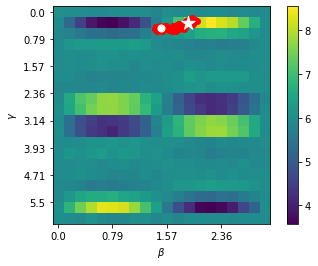

In [4]:
from classical_optimization.qaoa_circuits import try_optimizer, plot_history_over_landscape
import matplotlib.pyplot as plt
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model

noise_model = create_noise_model(cz_fidelity=.9)
history = []
try_optimizer('mgd', simulator, coupling_map, shots_per_point=1_000, weights=weights, max_gamma=max_gamma,
              max_beta=max_beta, rows=rows, cols=cols, history=history, initial_gamma_beta=[init_gamma, init_beta],
              noise_model=noise_model)
plot_history_over_landscape(history, landscape, discretization, max_gamma, max_beta)